# CNV Processing

In [1]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess
import urllib2

import cdpybio as cpb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'cnv_processing'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

rna_meta = rna_meta.merge(subject_meta, left_on='subject_id', right_index=True)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
gene_info['ensembl_id'] = [x.split('.')[0] for x in gene_info.index]

genes = pbt.BedTool(cpy.gencode_gene_bed)

exp = pd.read_table(os.path.join(ciepy.root, 'output', 'eqtl_input', 
                                 'tpm_log_filtered_phe_std_norm_peer_resid.tsv'), index_col=0)

In [3]:
fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

In [4]:
fn = '/projects/CARDIPS/pipeline/WGS/BF_GS_Discovery/eval/CopyNumberClass.report.dat'
report = pd.read_table(fn, index_col=0)

## Speedseq CNVs

## Genome Strip CNVs

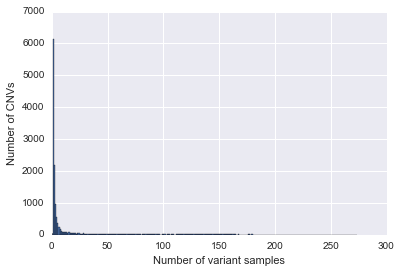

In [5]:
report.NVARIANT.hist(bins=range(275))
plt.ylabel('Number of CNVs')
plt.xlabel('Number of variant samples');

In [6]:
out = os.path.join(private_outdir, 'cnv_genotypes.tsv')
if not os.path.exists(out):
    fn = '/projects/CARDIPS/pipeline/WGS/BF_GS_Discovery/gs_cnv.genotypes.vcf'
    f = open(fn)
    line = f.readline()
    while line[0:2] == '##':
        line = f.readline()
    header = line[1:].strip().split('\t')

    ind = []
    copy_numbers = []
    line = f.readline().strip()
    while line != '':
        t = line.split('\t')
        ind.append(t[2])
        copy_numbers.append([int(x.split(':')[1]) for x in t[9:]])
        line = f.readline().strip()
    cns = pd.DataFrame(copy_numbers, index=ind, columns=header[9:])
    cns.to_csv(out, sep='\t')
else:
    cns = pd.read_table(out, index_col=0)

In [8]:
s = '\n'.join(cnv_info.chrom + '\t' + cnv_info.start.astype(str) + 
              '\t' + cnv_info.end.astype(str) + '\t' + cnv_info.name) + '\n'
cnv_bt = pbt.BedTool(s, from_string=True)
cnv_bt = cnv_bt.sort()
cnv_bt.saveas(os.path.join(outdir, 'cnvs.bed'), trackline="track type=bed name='CNVs'")
os.symlink(os.path.join(outdir, 'cnvs.bed'), '/home/cdeboever/public_html/cnvs.bed')

In [93]:
tt = res.to_dataframe()

In [98]:
len(cnv_bt[0].fields)

4

In [94]:
tt.head()

,chrom,start,end,name,score,strand,thickStart,thickEnd
0,chr1,55176,56686,CNV_1_55176_56686,chr1,53048,53049,-2128
1,chr1,85392,86406,CNV_1_85392_86406,chr1,91104,91105,4699
2,chr1,86407,91299,CNV_1_86407_91299,chr1,91104,91105,0
3,chr1,562952,567683,CNV_1_562952_567683,chr1,564389,564390,0
4,chr1,562952,567683,CNV_1_562952_567683,chr1,564441,564442,0


In [90]:
cnv_info = pd.DataFrame([x.split('_')[1:] for x in cns.index], 
                        index=cns.index, columns=['chrom', 'start', 'end'])
cnv_info['chrom'] = 'chr' + cnv_info.chrom
cnv_info['start'] = cnv_info.start.astype(int)
cnv_info['end'] = cnv_info.end.astype(int)
cnv_info['length'] = cnv_info.end - cnv_info.start
cnv_info['name'] = cnv_info.index
res = cnv_bt.intersect(genes, sorted=True, wo=True)
df = res.to_dataframe()
gb = df.groupby('name')
d = gb.groups
for k in d.keys():
    d[k] = list(df.ix[d[k], 'thickEnd'].values)
se = pd.Series(d)
cnv_info['gene_overlaps'] = np.nan
cnv_info.ix[se.index, 'gene_overlaps'] = se.apply(lambda x: ','.join(x))
tss_bt = pbt.BedTool('/publicdata/gencode_v19_20151104/tss_merged.bed')
res = cnv_bt.closest(tss_bt, D='b')
df = res.to_dataframe()
cnv_info.ix[df.name, 'nearest_tss_dist'] = df.thickEnd.values
cnv_info = cnv_info.join(report)
mode = cns.mode(axis=1)[0]
cnv_info['cn_mode'] = mode
nvariant = [sum(cns.ix[i] != cnv_info.ix[i, 'cn_mode']) for i in cnv_info.index]
cnv_info['diff_from_mode'] = nvariant
cnv_info['percent_diff_from_mode'] = cnv_info.diff_from_mode / cns.shape[1]
t = cns[rna_meta.ix[rna_meta.in_unrelateds, 'wgs_id']]
nvariant = [sum(t.ix[i] != cnv_info.ix[i, 'cn_mode']) for i in cnv_info.index]
cnv_info['unrelated_diff_from_mode'] = nvariant
cnv_info['unrelated_percent_diff_from_mode'] = cnv_info.unrelated_diff_from_mode / rna_meta.in_unrelateds.sum()
rna_meta_eqtl = rna_meta[rna_meta.in_eqtl]
vc = rna_meta_eqtl.family_id.value_counts()
vc = vc[vc > 4]
for x in vc.index:
    t = cns[rna_meta_eqtl.ix[rna_meta_eqtl.family_id == x, 'wgs_id']]
    pvariant = [sum(t.ix[i] != cnv_info.ix[i, 'cn_mode']) for i in cnv_info.index]
    cnv_info['{}_{}_diff_from_mode'.format(x, vc[x])] = np.array(pvariant)
    cnv_info['{}_{}_percent_diff_from_mode'.format(x, vc[x])] = np.array(pvariant) / float(vc[x])
family_cols = ['{}_{}_percent_diff_from_mode'.format(x, vc[x]) for x in vc.index]
cnv_info.to_csv(os.path.join(outdir, 'cnv_info.tsv'), sep='\t')

In [91]:
cnv_info.head().T

,CNV_1_55176_56686,CNV_1_85392_86406,CNV_1_86407_91299,CNV_1_562952_567683,CNV_1_565576_567883
chrom,chr1,chr1,chr1,chr1,chr1
start,55176,85392,86407,562952,565576
end,56686,86406,91299,567683,567883
length,1510,1014,4892,4731,2307
name,CNV_1_55176_56686,CNV_1_85392_86406,CNV_1_86407_91299,CNV_1_562952_567683,CNV_1_565576_567883
gene_overlaps,NaN,NaN,"ENSG00000238009.2,ENSG00000239945.1","ENSG00000230021.3,ENSG00000223659.1,ENSG000002...","ENSG00000230021.3,ENSG00000225630.1,ENSG000002..."
nearest_tss_dist,-2128,4699,0,0,0
CALLRATE,0.96,0.942,1,0.901,0.934
CNMIN,0,0,0,0,0
CNMAX,5,5,4,18,20


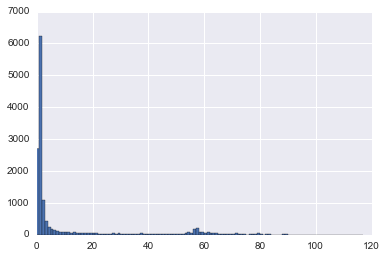

In [78]:
cnv_info.unrelated_diff_from_mode.hist(bins=range(118))

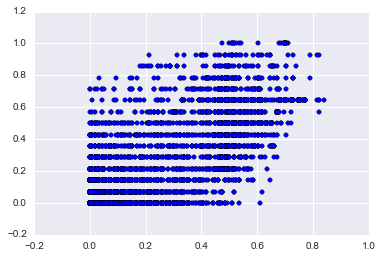

In [308]:
plt.scatter(cnv_info.unrelated_percent_diff_from_mode, cnv_info[family_cols[0]])

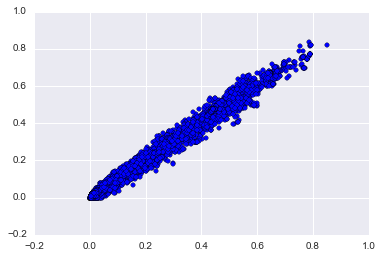

In [277]:
p1 = cnv_info.diff_from_mode / cns.shape[1]
p2 = cnv_info.unrelated_diff_from_mode / rna_meta.in_unrelateds.sum()
diff = p1 - p2
diff.sort_values(inplace=True)
plt.scatter(p1, p2)

In [282]:
diff.head()

CNV_1_565853_567683         -0.106396
CNV_19_55246790_55248087    -0.105097
CNV_1_149240401_149245571   -0.103241
CNV_8_131850793_131852692   -0.098416
CNV_9_36362952_36364076     -0.091798
dtype: float64

In [283]:
diff.tail()

CNV_19_55260924_55265523     0.118768
CNV_19_55245253_55246951     0.119943
CNV_2_118408441_118412348    0.121304
CNV_19_55283794_55288263     0.122417
CNV_19_55288966_55291862     0.122417
dtype: float64

In [268]:
cnv_info.cn_mode.value_counts()

2     13216
1       404
4       274
0       220
3       180
6        94
5        59
8        23
12       15
7         9
13        3
10        2
9         1
Name: cn_mode, dtype: int64

In [27]:
cnv_info.length.hist?

In [28]:
?plt.hist

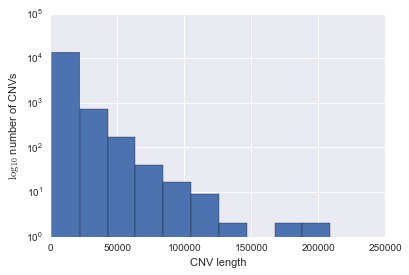

In [26]:
cnv_info.length.hist(log=True, )
plt.ylabel('$\log_{10}$ number of CNVs')
plt.xlabel('CNV length');

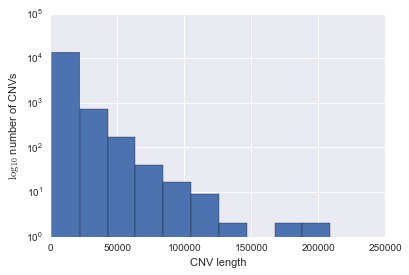

In [8]:
cnv_info.length.hist(log=True)
plt.ylabel('$\log_{10}$ number of CNVs')
plt.xlabel('CNV length');

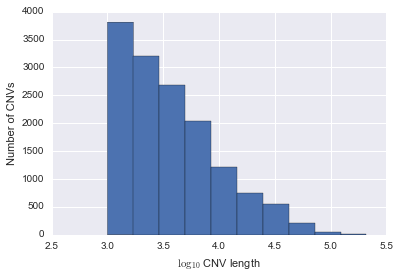

In [9]:
(np.log10(cnv_info.length)).hist()
plt.ylabel('Number of CNVs')
plt.xlabel('$\log_{10}$ CNV length');

In [10]:
cnv_info.length.describe()

count     14500.000000
mean       6615.005931
std       10552.781125
min         999.000000
25%        1660.000000
50%        3049.000000
75%        6574.250000
max      208946.000000
Name: length, dtype: float64

In [11]:
cutoffs = np.array([2, 5, 10, 50, 100, 200]) * 1000
for c in cutoffs:
    print('{:.1f}% of CNVs are less than {:,} bp'.format(
            100 * sum(cnv_info.length < c) / float(cnv_info.shape[0]), c))

32.7% of CNVs are less than 2,000 bp
67.2% of CNVs are less than 5,000 bp
84.1% of CNVs are less than 10,000 bp
99.0% of CNVs are less than 50,000 bp
99.9% of CNVs are less than 100,000 bp
100.0% of CNVs are less than 200,000 bp


### Functional annotations

I'm going to annotate the CNVs with more info.

In [20]:
from ipyparallel import Client
parallel_client = Client(profile='parallel')
dview = parallel_client[:]
print('Cluster has {} engines.'.format(len(parallel_client.ids)))

Cluster has 250 engines.


In [21]:
with dview.sync_imports():
    import cdpybio
    import pandas
    import pybedtools

importing cdpybio on engine(s)
importing pandas on engine(s)
importing pybedtools on engine(s)


In [22]:
%px cpb = cdpybio
%px pd = pandas
%px pbt = pybedtools

In [23]:
def cnv_counts(url, name):
    bt = pbt.BedTool(cpb.general.read_gzipped_text_url(url), from_string=True)
    bt = bt.sort()
    res = cnv_bt.intersect(bt, sorted=True, wo=True)
    r = res[0]
    df = res.to_dataframe(names=range(len(res[0].fields)))
    vc = df[3].value_counts()
    counts = pd.DataFrame(0, columns=[name], index=cnv_info.index)
    counts.ix[vc.index, name] = vc
    return counts

In [24]:
dview.push(dict(cnv_bt=cnv_bt, cnv_info=cnv_info, 
                cnv_counts=cnv_counts));

#### Roadmap DNase and ChIP-seq

In [25]:
out = os.path.join(outdir, 'roadmap_overlap.tsv')
if not os.path.exists(out):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(.*\.gz)"', html)
    lines = [x for x in roadmap_ids.index if ('ES' in roadmap_ids[x] and 'Cultured' not in roadmap_ids[x])]
    lines += [x for x in roadmap_ids.index if 'iPS' in roadmap_ids[x]]
    files = [x for x in files if x.split('-')[0] in lines]
    files = [x for x in files if 'hotspot' not in x]

    roadmap_peak_pvals = pd.DataFrame(
        -1, index=lines, 
        columns=set([x.split('-')[1].split('.')[0] for x in files]))
    roadmap_peak_oddsratios = pd.DataFrame(
        0, index=lines, 
        columns=set([x.split('-')[1].split('.')[0] for x in files]))

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    lines = [roadmap_ids[re.findall('E\d{3}', url)[0]][0:-10].replace(' ', '_') for url in urls]
    btype = [re.findall('-(.+)\.', url)[0].split('.')[0] for url in urls]
    names = ['{}_{}'.format(lines[i], btype[i]) for i in range(len(lines))]
    todo = zip(urls, names)
    counts = dview.map_sync(lambda x: cnv_counts(x[0], x[1]), todo)
    roadmap_dnase_counts = pd.concat(counts, axis=1)
    roadmap_dnase_counts.to_csv(out, sep='\t')
else:
    roadmap_dnase_counts = pd.read_table(out, index_col=0)

#### Roadmap chromatin state

In [199]:
lines = [x for x in roadmap_ids.index if 'iPS' in roadmap_ids[x]]
for line in lines:
    fn = ('/publicdata/roadmap_25_state_20151104/'
          '{}_25_imputed12marks_mnemonics_sorted.bed'.format(line))
    bt = pbt.BedTool(fn)
    res = cnv_bt.intersect(bt, sorted=True, wo=True)
    df = res.to_dataframe(names=range(len(res[0].fields)))
    c = df.groupby([3, 7]).sum()[8]
    c = c.sort_values(ascending=False)
    t = c.unstack()
    t[t.isnull()] = 0
    name = roadmap_ids[line][:-10].replace(' ', '_')
    t.to_csv(os.path.join(outdir, '{}_chromatin_state.tsv'.format(name)), sep='\t')

#### ENCODE DNase

In [198]:
out = os.path.join(outdir, 'encode_dnase_overlap.tsv')
if not os.path.exists(out):
    encode_dnase = pd.read_table(os.path.join(ciepy.root, 'output', 
                                              'functional_annotation_analysis', 
                                              'encode_dnase.tsv'), index_col=0)
    encode_dnase = encode_dnase[encode_dnase.biosample_type == 'stem cell']
    encode_dnase['name'] = encode_dnase.cell_type + '_' + 'DNase'
    dview.push(dict(encode_dnase=encode_dnase));
    counts = dview.map_sync(lambda i: cnv_counts(encode_dnase.ix[i, 'narrowPeak_url'], 
                                                 encode_dnase.ix[i, 'name']), 
                            encode_dnase.index)
    encode_dnase_counts = pd.concat(counts, axis=1)
    encode_dnase_counts.to_csv(out, sep='\t')
else:
    encode_dnase_counts = pd.read_table(out, index_col=0)

#### ENCODE ChIP-seq

In [200]:
out = os.path.join(outdir, 'encode_tf_chip_seq_overlap.tsv')
if not os.path.exists(out):
    encode_tf_chip_seq = pd.read_table(os.path.join(ciepy.root, 'output', 
                                                    'functional_annotation_analysis', 
                                                    'encode_stem_cell_chip_seq.tsv'), index_col=0)
    encode_tf_chip_seq = encode_tf_chip_seq.drop_duplicates(subset='target')
    encode_tf_chip_seq['name'] = encode_tf_chip_seq.cell_type + '-' + encode_tf_chip_seq.target
    dview.push(dict(encode_tf_chip_seq=encode_tf_chip_seq));
    counts = dview.map_sync(lambda i: cnv_counts(encode_tf_chip_seq.ix[i, 'narrowPeak_url'], 
                                                 encode_tf_chip_seq.ix[i, 'name']), 
                            encode_tf_chip_seq.index)
    encode_tf_chip_seq_counts = pd.concat(counts, axis=1)
    encode_tf_chip_seq_counts.to_csv(out, sep='\t')
else:
    encode_tf_chip_seq_counts = pd.read_table(out, index_col=0)

## EMMAX CNVs

I want to find CNVs that I can include in the EMMAX association analysis. 
These will be CNVs that have at most three copy number states and have a
minor allele frequency greater than 5%.

I can also separately test mCNVs for an association with gene expression.

In [204]:
cns_f = cns[rna_meta[rna_meta.in_eqtl].wgs_id]
num_states = cns_f.apply(lambda x: len(set(x)), axis=1)
cns_emmax = cns_f.ix[num_states[num_states.apply(lambda x: x in [2, 3])].index]

In [205]:
b = (cns_emmax.apply(lambda x: x.value_counts().max() < 
                     cns_emmax.shape[1] - np.floor(rna_meta.in_eqtl.sum() * 0.05), axis=1))
cns_emmax = cns_emmax[b]

In [206]:
maj_af = cns_emmax.apply(lambda x: x.value_counts().max(), axis=1) / cns_emmax.shape[1]

In [207]:
t = cnv_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()

fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'variant_regions.bed')
variant_regions = pbt.BedTool(fn)
genes_todo = set(exp.index)

res = cns_emmax_bt.intersect(variant_regions, sorted=True, wo=True)
g = []
for r in res:
    g.append(r.fields[-3].split('_')[0])
cnv_gene_vc = pd.Series(g).value_counts()
cnv_gene_vc = cnv_gene_vc[set(cnv_gene_vc.index) & genes_todo]

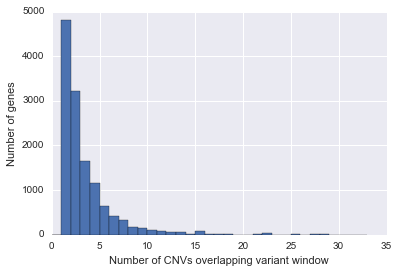

In [208]:
cnv_gene_vc.hist(bins=range(cnv_gene_vc.max()))
plt.ylabel('Number of genes')
plt.xlabel('Number of CNVs overlapping variant window');

I think that I can collapse some mCNVs to be biallelic. For instance, the CNV
below has one person with copy number 4, but if we exclude that person, we would
only have three copy number states. The person who is four is likely just an error and
should actually be 3, or at the least it wouldn't hurt to make them copy number 3 or 
just not include them in the analysis.

In [209]:
report.ix['CNV_19_40372246_40375846']

CALLRATE               0.989
CNMIN                      1
CNMAX                      4
CNALLELES                  3
NNONREF                  140
NVARIANT                 140
CNCATEGORY             MIXED
CNDIST        0,109,131,30,1
Name: CNV_19_40372246_40375846, dtype: object

In [210]:
t = cns_f.ix[set(cns_f.index) - set(cns_emmax.index)]
t = t[t.apply(lambda x: len(set(x)) > 3, axis=1)]
b = t.apply(lambda x: x.value_counts()[0:3].sum(), axis=1)

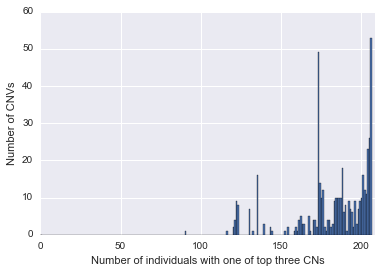

In [211]:
b.hist(bins=range(208))
plt.xlim(0, 209)
plt.ylabel('Number of CNVs')
plt.xlabel('Number of individuals with one of top three CNs');

This plot shows us that many CNVs are almost biallelic. If we remove 
a few samples, we can make more sites biallelic.

In [212]:
sum(b >= rna_meta.in_eqtl.sum() * 0.95)

807

There are 807 CNVs for which I can remove people with rare copy numbers
and still have 95% call rate. I'll set the rare copy numbers to missing
and include these.

In [213]:
rows = []
for i in b[b >= rna_meta.in_eqtl.sum() * 0.95].index:
    se = cns_f.ix[i]
    vc = se.value_counts()
    se[se.apply(lambda x: x not in vc.index[0:3])] = np.nan
    rows.append(se)
df = pd.DataFrame(rows, index=b[b >= rna_meta.in_eqtl.sum() * 0.95].index, 
                  columns=cns_f.columns)

In [214]:
b = df.apply(lambda x: x.value_counts().max() < df.shape[1] - np.floor(rna_meta.in_eqtl.sum() * 0.05), axis=1)
df = df[b]

In [215]:
cns_emmax = pd.concat([cns_emmax, df])
cns_emmax.to_csv(os.path.join(private_outdir, 'emmax_cnvs.tsv'), sep='\t')

In [216]:
cns_emmax.shape

(3222, 215)

I'll write a VCF file with the CNV genotypes.

In [217]:
cns_emmax_genotypes = cns_emmax.copy(deep=True).astype(str)
mins = cns_emmax.apply(lambda x: x == x.min(), axis=1)
maxs = cns_emmax.apply(lambda x: x == x.max(), axis=1)
nulls = cns_emmax.isnull()
hets = (mins.astype(int) + maxs.astype(int) + nulls.astype(int) == 0)
cns_emmax_genotypes[mins] = '0/0'
cns_emmax_genotypes[hets] = '0/1'
cns_emmax_genotypes[maxs] = '1/1'
cns_emmax_genotypes[nulls] = './.'

In [218]:
cns_emmax_info = cnv_info.ix[cns_emmax.index]
cns_emmax_info.chrom = cns_emmax_info.chrom.apply(lambda x: x[3:])
cns_emmax_info = cns_emmax_info.drop(['end', 'length'], axis=1)
cns_emmax_info.start = cns_emmax_info.start.astype(str)
cns_emmax_info['ref'] = 'N'
cns_emmax_info['alt'] = 'N'
cns_emmax_info['qual'] = '100000'
cns_emmax_info['filter'] = 'PASS'
cns_emmax_info['info'] = ''
cns_emmax_info['format'] = 'GT'
cns_emmax_info = cns_emmax_info.join(cns_emmax_genotypes[sorted(cns_emmax_genotypes.columns)])

In [219]:
with open('/projects/CARDIPS/analysis/cardips-ipsc-eqtl/misc/header.vcf') as f:
    lines = f.readlines()
vs = lines[-1].strip().split('\t')[9:]
colnames = lines[-1].strip().split('\t')[0:9]

In [ ]:
out = os.path.join(private_outdir, 'emmax_sorted.vcf')
if not os.path.exists(out):
    with open(os.path.join(private_outdir, 'emmax.vcf'), 'w') as f:
        f.write(''.join(lines[0:-1]))
        f.write('\t'.join(colnames + list(cns_emmax_info.columns[9:])) + '\n')
        f.write('\n'.join(cns_emmax_info.apply(lambda x: '\t'.join(x), axis=1)) + '\n')
    !cat {os.path.join(private_outdir, 'emmax.vcf')} | vcf-sort > {out}
    !bgzip {out}
    !bcftools index {out}.gz
    !bcftools index -t {out}.gz
    !rm {os.path.join(private_outdir, 'emmax.vcf')}

Let's see which genes have CNVs to test now that we've added in some more CNVs.

In [221]:
t = cnv_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()

res = cns_emmax_bt.intersect(variant_regions, sorted=True, wo=True)
g = []
for r in res:
    g.append(r.fields[-3].split('_')[0])
cnv_gene_vc = pd.Series(g).value_counts()
cnv_gene_vc = cnv_gene_vc[set(cnv_gene_vc.index) & genes_todo]

In [222]:
t = cnv_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()

In [223]:
cnv_gene_vc.shape

(13631,)

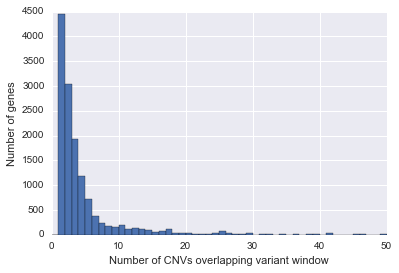

In [224]:
cnv_gene_vc.hist(bins=range(cnv_gene_vc.max()))
plt.ylabel('Number of genes')
plt.xlabel('Number of CNVs overlapping variant window');

## mCNVs

I want to identify mCNVs that I can test for associations with gene expression. 
I'll filter the mCNVs more in the notebook where I do the analysis.

In [38]:
mcnvs = cns_f.ix[num_states[num_states > 3].index]
mcnvs_f = mcnvs.ix[set(mcnvs.index) - set(cns_emmax.index)]
mcnvs_f.to_csv(os.path.join(private_outdir, 'mcnvs.tsv'), sep='\t')